# HBV hydrological model forced with ERA5 forcing data
In this notebook we will demonstrate how to generate forcing data for the HBV hydrological model from the ERA5 dataset using the eWaterCycle platform. It is assumed that you already have seen [this notebook which explains the basics of the HBV model and generating forcing using eWaterCycle](example_model_run_HBV_camels_catchment_camels_forcing.ipynb). This notebooks purely focuses on the differences when generating forcing from ERA5.

Below a few collapsed cells are identical to those from that notebook.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

## Generate or load forcing
when generating forcing using eWaterCycle there are two important choices to make: dataset that the data comes from and type of forcing that the model requires. The dataset in this example is ERA5. The HBV model in eWaterCycle needs potential evaporation data. Both the 'caravan' type forcing as well as the 'LumpedMakkinkForcing' provide potential evaporation. Note that the 'caravan' type forcing only works with the 'caravan' dataset as well, so here we select 'ERA5 for the dataset and LumpedMakkinkForcing for the type.

Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

More complex models often require their own type of forcing, for example the wflow model requires 'wflow' type forcing specifically designed for that model, but this is not the case for HBV in eWaterCycle.

In [4]:
# Load calibration constants from a csv file
par_0 = np.loadtxt(Path(settings["base_path"]) / "data" / (settings["caravan_id"] + settings['caravan_id'] + "_params_SCE.csv"), delimiter = ",")

In [5]:
# Print parameter names and values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 4.389),
    ('Ce', 0.99),
    ('Sumax', 40.981),
    ('Beta', 2.743),
    ('Pmax', 0.004),
    ('Tlag', 1.0),
    ('Kf', 0.1),
    ('Ks', 0.009),
    ('FM', 5.765)
]

In [6]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [7]:
model_output = dict()

for dataset_name in settings['CMIP_info']['dataset']: 
    # We are asuming one dataset, but this loop allows for multiple
    print(dataset_name)

   
    for experiment_name in settings['CMIP_info']['experiments'][1:]: #skipping historical
        print(experiment_name)

    
        for ensemble_name in settings['CMIP_info']['ensembles']:
            print(ensemble_name)

            model_run_name = dataset_name + "," + experiment_name + "," + ensemble_name

            cmip_dataset = {
                "dataset": dataset_name,
                "project": settings['CMIP_info']['project'],
                "grid": "gn",
                "exp": experiment_name,
                "ensemble": ensemble_name,
            }
        
            # Create a subfolder for this specific combination of dataset, experiment and ensemblemember
            path_CMIP6 = Path(settings['path_CMIP6']) / cmip_dataset["dataset"] / cmip_dataset["exp"] / cmip_dataset["ensemble"]
            load_location = path_CMIP6 / "work" / "diagnostic" / "script" 
            CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

            model = ewatercycle.models.HBVLocal(forcing=CMIP_forcing_object)

            # Create config file in model.setup()
            config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
            # Initialize model
            model.initialize(config_file)
            # Run model, capture calculated discharge and timestamps
            Q_m = []
            time = []
            while model.time < model.end_time:
                model.update()
                Q_m.append(model.get_value("Q")[0])
                time.append(pd.Timestamp(model.time_as_datetime))
            # Finalize model (shuts down container, frees memory)
            model.finalize()
        
            # Make a pandas series
            model_output[model_run_name] = pd.Series(data=Q_m, name="modelled discharge, forcing: " + model_run_name, index=time)

MPI-ESM1-2-HR

ssp126

r1i1p1f1

ssp245

r1i1p1f1

ssp370

r1i1p1f1

ssp585

r1i1p1f1

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [8]:
# We want to also be able to use the output of this model run in different analyses. Therefore, we save it as a NetCDF file.
xr_model_output = xr.merge([model_output_per_model.to_xarray() for name, model_output_per_model in model_output.items()])
xr_model_output = xr_model_output.rename({'index': 'time'})
xr_model_output.attrs['units'] = 'mm/d'
print(xr_model_output)


<xarray.Dataset> Size: 307kB
Dimensions:                                                     (time: 7669)
Coordinates:
  * time                                                        (time) datetime64[ns] 61kB ...
Data variables:
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp126,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp245,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp370,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp585,r1i1p1f1  (time) float64 61kB ...
Attributes:
    units:    mm/d

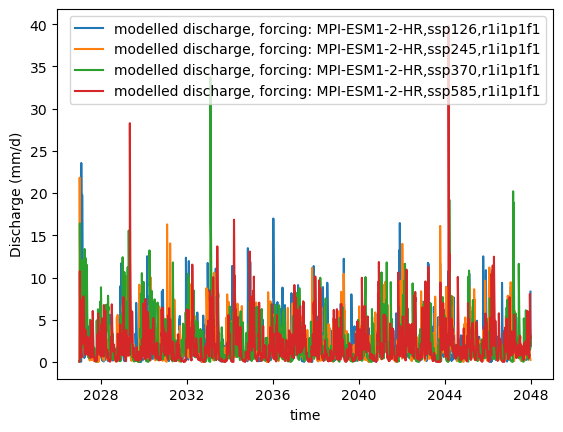

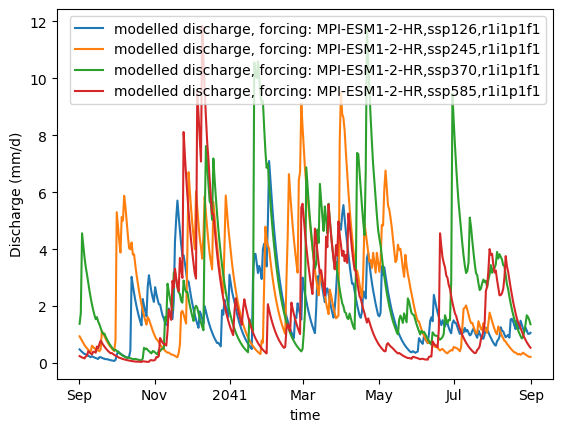

In [9]:
def plot_hydrograph(data_array):
    plt.figure()
    for var in data_array.data_vars:
        data_array[var].plot(label=var)
    plt.ylabel("Discharge (mm/d)")
    plt.legend()


xr_one_year = xr_model_output.sel(time=slice('2040-09-01', '2041-08-31'))

plot_hydrograph(xr_model_output)
plot_hydrograph(xr_one_year)

In [10]:
# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf(Path(settings['base_path']) / (settings['caravan_id'] + '_future_output.nc'))

In [11]:
# Remove all temporary directories made by the optimization algo.

!rm -rf hbvlocal*